# Boosting

Boosting (originally called hypothesis boosting) refers to any Ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. There are many boosting methods available, but by far the most popular are AdaBoost13 (short for Adaptive Boosting) and Gradient Boosting. Let’s start with AdaBoost.


## Adaboost

One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfitted. This results in new predictors focusing more and more on the hard cases. This is the technique used by AdaBoost.

For example, to build an AdaBoost classifier, a first base classifier (such as a Decision Tree) is trained and used to make predictions on the training set. The relative weight of misclassified training instances is then increased. A second classifier is trained using the updated weights and again it makes predictions on the training set, weights are updated, and so on.

<img src='images/img6.PNG'>

Following image shows the decision boundaries of five consecutive predictors on the moons dataset (in this example, each predictor is a highly regularized SVM classifier with an RBF kernel14). The first classifier gets many instances wrong, so their weights get boosted. The second classifier therefore does a better job on these instances, and so on. The plot on the right represents the same sequence of predictors except that the learning rate is halved (i.e., the misclassified instance weights are boosted half as much at every iteration). As you can see, this sequential learning technique has some similarities with Gradient Descent, except that instead of tweaking a single predictor’s parameters to minimize a cost function, AdaBoost adds predictors to the ensemble, gradually making it better.

<img src='images/img7.PNG'>


Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, except that predictors have different weights depending on their overall accuracy on the weighted training set.

Let’s take a closer look at the AdaBoost algorithm. Each instance weight w(i) is initially set to 1/m . A first predictor is trained and its weighted error rate r1 is computed on the training set;

<img src='images/img8.PNG'>

The predictor’s weight αj is then computed using Equation given below, where η is the learning rate hyperparameter (defaults to 1). The more accurate the predictor is, the higher its weight will be. If it is just guessing randomly, then its weight will be close to zero. However, if it is most often wrong (i.e., less accurate than random guessing), then its weight will be negative.

<img src='images/img9.PNG'>

Next the instance weights are updated using following equation: the misclassified instances are boosted.

<img src='images/img10.PNG'>

Then all the instance weights are normalized (i.e., divided by <img src='images/img11.PNG'>).

Finally, a new predictor is trained using the updated weights, and the whole process is repeated (the new predictor’s weight is computed, the instance weights are updated, then another predictor is trained, and so on). The algorithm stops when the desired number of predictors is reached, or when a perfect predictor is found. 

To make predictions, AdaBoost simply computes the predictions of all the predictors and weighs them using the predictor weights αj. The predicted class is the one that receives the majority of weighted votes:

<img src='images/img12.PNG'>

Scikit-Learn actually uses a multiclass version of AdaBoost called SAMME16 (which stands for Stagewise Additive Modeling using a Multiclass Exponential loss function). When there are just two classes, SAMME is equivalent to AdaBoost. Moreover, if the predictors can estimate class probabilities (i.e., if they have a predict_proba() method), Scikit-Learn can use a variant of SAMME called SAMME.R (the R stands for “Real”), which relies on class probabilities rather than predictions and generally performs better. 

The following code trains an AdaBoost classifier based on 200 Decision Stumps using Scikit-Learn’s AdaBoostClassifier class (as you might expect, there is also an AdaBoostRegressor class). A Decision Stump is a Decision Tree with max_depth=1 — in other words, a tree composed of a single decision node plus two leaf nodes. This is the default base estimator for the AdaBoostClassifier class: 

In [4]:
# Import dataset and prepare..
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X_train,y_train=make_moons()

# Split into training and testing
X_train,X_test,y_train,y_test=train_test_split(X_train,y_train)

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

ada_clf=AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=200,algorithm='SAMME.R',learning_rate=0.5)
ada_clf.fit(X_train,y_train)
print(ada_clf.score(X_train,y_train))

1.0


###### Tip: If your AdaBoost ensemble is overfitting the training set, you can try reducing the number of estimators or more strongly regularizing the base estimator.


# Gradient Boosting

Another very popular Boosting algorithm is Gradient Boosting.17 Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor. 

Let’s go through a simple regression example using Decision Trees as the base predictors (of course Gradient Boosting also works great with regression tasks). This is called Gradient Tree Boosting, or Gradient Boosted Regression Trees (GBRT). First, let’s fit a DecisionTreeRegressor to the training set (for example, a noisy quadratic training set): 

In [18]:
tree_reg=DecisionTreeClassifier(max_depth=2)
tree_reg.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [20]:
# Now train the second DecisionTreeRegressor on the residual errors made by the first predictor:
y_train2=y_train - tree_reg.predict(X_train)

tree_reg2=DecisionTreeClassifier(max_depth=2)
tree_reg2.fit(X_train,y_train2)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [21]:
# Then we train a third regressor on the residual errors made by the second predictor:

y_train3=y_train2 - tree_reg2.predict(X_train)
tree_reg3=DecisionTreeClassifier(max_depth=2)
tree_reg3.fit(X_train,y_train3)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [23]:
# Now we have an ensemble containing three trees.
# It can make predictions on a new instance simply by adding up the predictions of all the trees:


y_pred=sum(tree.predict(X_test) for tree in (tree_reg,tree_reg2,tree_reg3))

Following picture represents the predictions of these three trees in the left column, and the ensemble’s predictions in the right column. In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions. In the second row, a new tree is trained on the residual errors of the first tree. On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees. Similarly, in the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.

A simpler way to train GBRT ensembles is to use Scikit-Learn’s GradientBoostingRegressor class. Much like the RandomForestRegressor class, it has hyperparameters to control the growth of Decision Trees (e.g., max_depth, min_samples_leaf, and so on), as well as hyperparameters to control the ensemble training, such as the number of trees (n_estimators). The following code creates the same ensemble as the previous one: 

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt=GradientBoostingClassifier(max_depth=2,n_estimators=3,learning_rate=1.0)
gbrt.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=3, presort='auto',
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

<img src='images/img13.PNG'>

The learning_rate hyperparameter scales the contribution of each tree. If you set it to a low value, such as 0.1, you will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better. This is a regularization technique called shrinkage. Figure below shows two GBRT ensembles trained with a low learning rate: the one on the left does not have enough trees to fit the training set, while the one on the right has too many trees and overfits the training set.

<img src='images/img14.PNG'>

In order to find the optimal number of trees, you can use early stopping. A simple way to implement this is to use the staged_predict() method: it returns an iterator over the predictions made by the ensemble at each stage of training (with one tree, two trees, etc.). The following code trains a GBRT ensemble with 120 trees, then measures the validation error at each stage of training to find the optimal number of trees, and finally trains another GBRT ensemble using the optimal number of trees:



In [29]:
import numpy as np
from sklearn.metrics import mean_squared_error

gbrt=GradientBoostingClassifier(max_depth=2,n_estimators=120)
gbrt.fit(X_train,y_train)

errors=[mean_squared_error(y_test,y_pred) for y_pred in gbrt.staged_predict(X_test)]
bst_n_estimators=np.argmin(errors)

gbrt_best=GradientBoostingClassifier(max_depth=2,n_estimators=bst_n_estimators)
gbrt_best.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=14,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

The validation errors are represented on the left of below figure, and the best model's predictions are represented on the right.

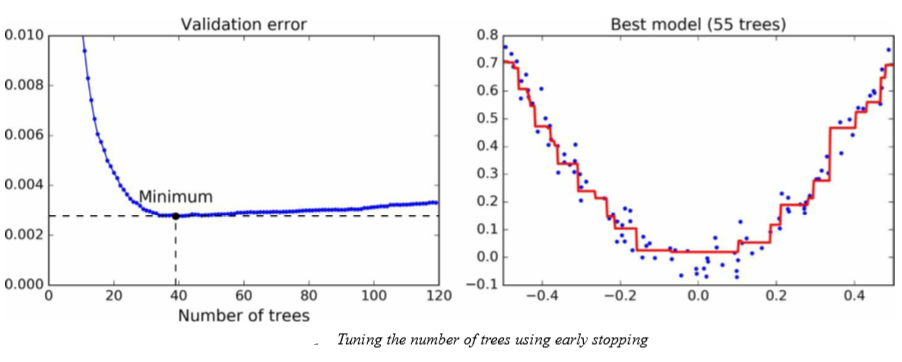

It is also possible to implement early stopping by actually stopping training early (instead of training a large number of trees first and then looking back to find the optimal number). You can do so by setting warm_start=True, which makes Scikit-Learn keep existing trees when the fit() method is called, allowing incremental training. The following code stops training when the validation error does not improve for five iterations in a row:


In [31]:
gbrt=GradientBoostingClassifier(max_depth=2,warm_start=True)

min_val_error=float('inf')
error_going_up=0
for n_estimator in range(1,120):
    gbrt.n_estimators=n_estimator
    gbrt.fit(X_train,y_train)
    y_pred=gbrt.predict(X_test)
    val_error=mean_squared_error(y_test,y_pred)
    if val_error<min_val_error:
        min_val_error=val_error
        error_going_up=0
    else:
        error_going_up+=1
        if error_going_up==5:
            break # early stopping

The GradientBoostingRegressor class also supports a subsample hyperparameter, which specifies the fraction of training instances to be used for training each tree. For example, if subsample=0.25, then each tree is trained on 25% of the training instances, selected randomly. As you can probably guess by now, this trades a higher bias for a lower variance. It also speeds up training considerably. This technique is called Stochastic Gradient Boosting.
